In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import io

In [2]:
data_dir = './data/moc./dataset'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
data_root = pathlib.Path(data_dir)

In [5]:
data_root

WindowsPath('data/moc./dataset')

In [6]:
all_img_path = list(data_root.glob('*/*'))

In [7]:
img_count = len(all_img_path)
img_count

2525

In [8]:
all_img_path[:3]

[WindowsPath('data/moc./dataset/black_jeans/00000000.jpg'),
 WindowsPath('data/moc./dataset/black_jeans/00000001.jpeg'),
 WindowsPath('data/moc./dataset/black_jeans/00000002.jpeg')]

In [9]:
all_img_path[-3:]

[WindowsPath('data/moc./dataset/red_shirt/00000383.jpg'),
 WindowsPath('data/moc./dataset/red_shirt/00000386.jpeg'),
 WindowsPath('data/moc./dataset/red_shirt/00000388.jpg')]

In [10]:
import random
all_img_path = [str(path) for path in all_img_path]
random.shuffle(all_img_path)

In [11]:
all_img_path[:5]

['data\\moc.\\dataset\\blue_jeans\\00000200.jpg',
 'data\\moc.\\dataset\\black_jeans\\00000207.jpeg',
 'data\\moc.\\dataset\\blue_dress\\00000109.jpg',
 'data\\moc.\\dataset\\black_jeans\\00000130.jpg',
 'data\\moc.\\dataset\\red_dress\\00000302.jpeg']

In [12]:
label_names = sorted(item.name for item in data_root.glob('./*/') if item.is_dir())
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']

In [13]:
color_label_names = set(name.split('_')[0] for name in label_names)
color_label_names

{'black', 'blue', 'red'}

In [14]:
item_label_names = set(name.split('_')[1] for name in label_names)
item_label_names

{'dress', 'jeans', 'shirt', 'shoes'}

In [15]:
color_label_to_index = dict((name, index) for index,name in enumerate(color_label_names))
color_label_to_index

{'red': 0, 'blue': 1, 'black': 2}

In [16]:
item_label_to_index = dict((name, index) for index,name in enumerate(item_label_names))
item_label_to_index

{'dress': 0, 'shirt': 1, 'jeans': 2, 'shoes': 3}

In [90]:
color_index_to_label = dict((index, name) for index,name in enumerate(color_label_names))
color_index_to_label

{0: 'red', 1: 'blue', 2: 'black'}

In [91]:
item_index_to_label = dict((index, name) for index,name in enumerate(item_label_names))
item_index_to_label

{0: 'dress', 1: 'shirt', 2: 'jeans', 3: 'shoes'}

In [17]:
all_img_labels = [pathlib.Path(path).parent.name for path in all_img_path]
all_img_labels[:5]

['blue_jeans', 'black_jeans', 'blue_dress', 'black_jeans', 'red_dress']

In [18]:
color_labels = [color_label_to_index[label.split('_')[0]] for label in all_img_labels]
color_labels[:5]

[1, 2, 1, 2, 0]

In [19]:
item_labels = [item_label_to_index[label.split('_')[1]] for label in all_img_labels]
item_labels[:10]

[2, 2, 0, 2, 0, 2, 3, 2, 0, 2]

In [20]:
import IPython.display as display

def caption_image(label):return{0:'airplane', 1:'lake'}.get(label)

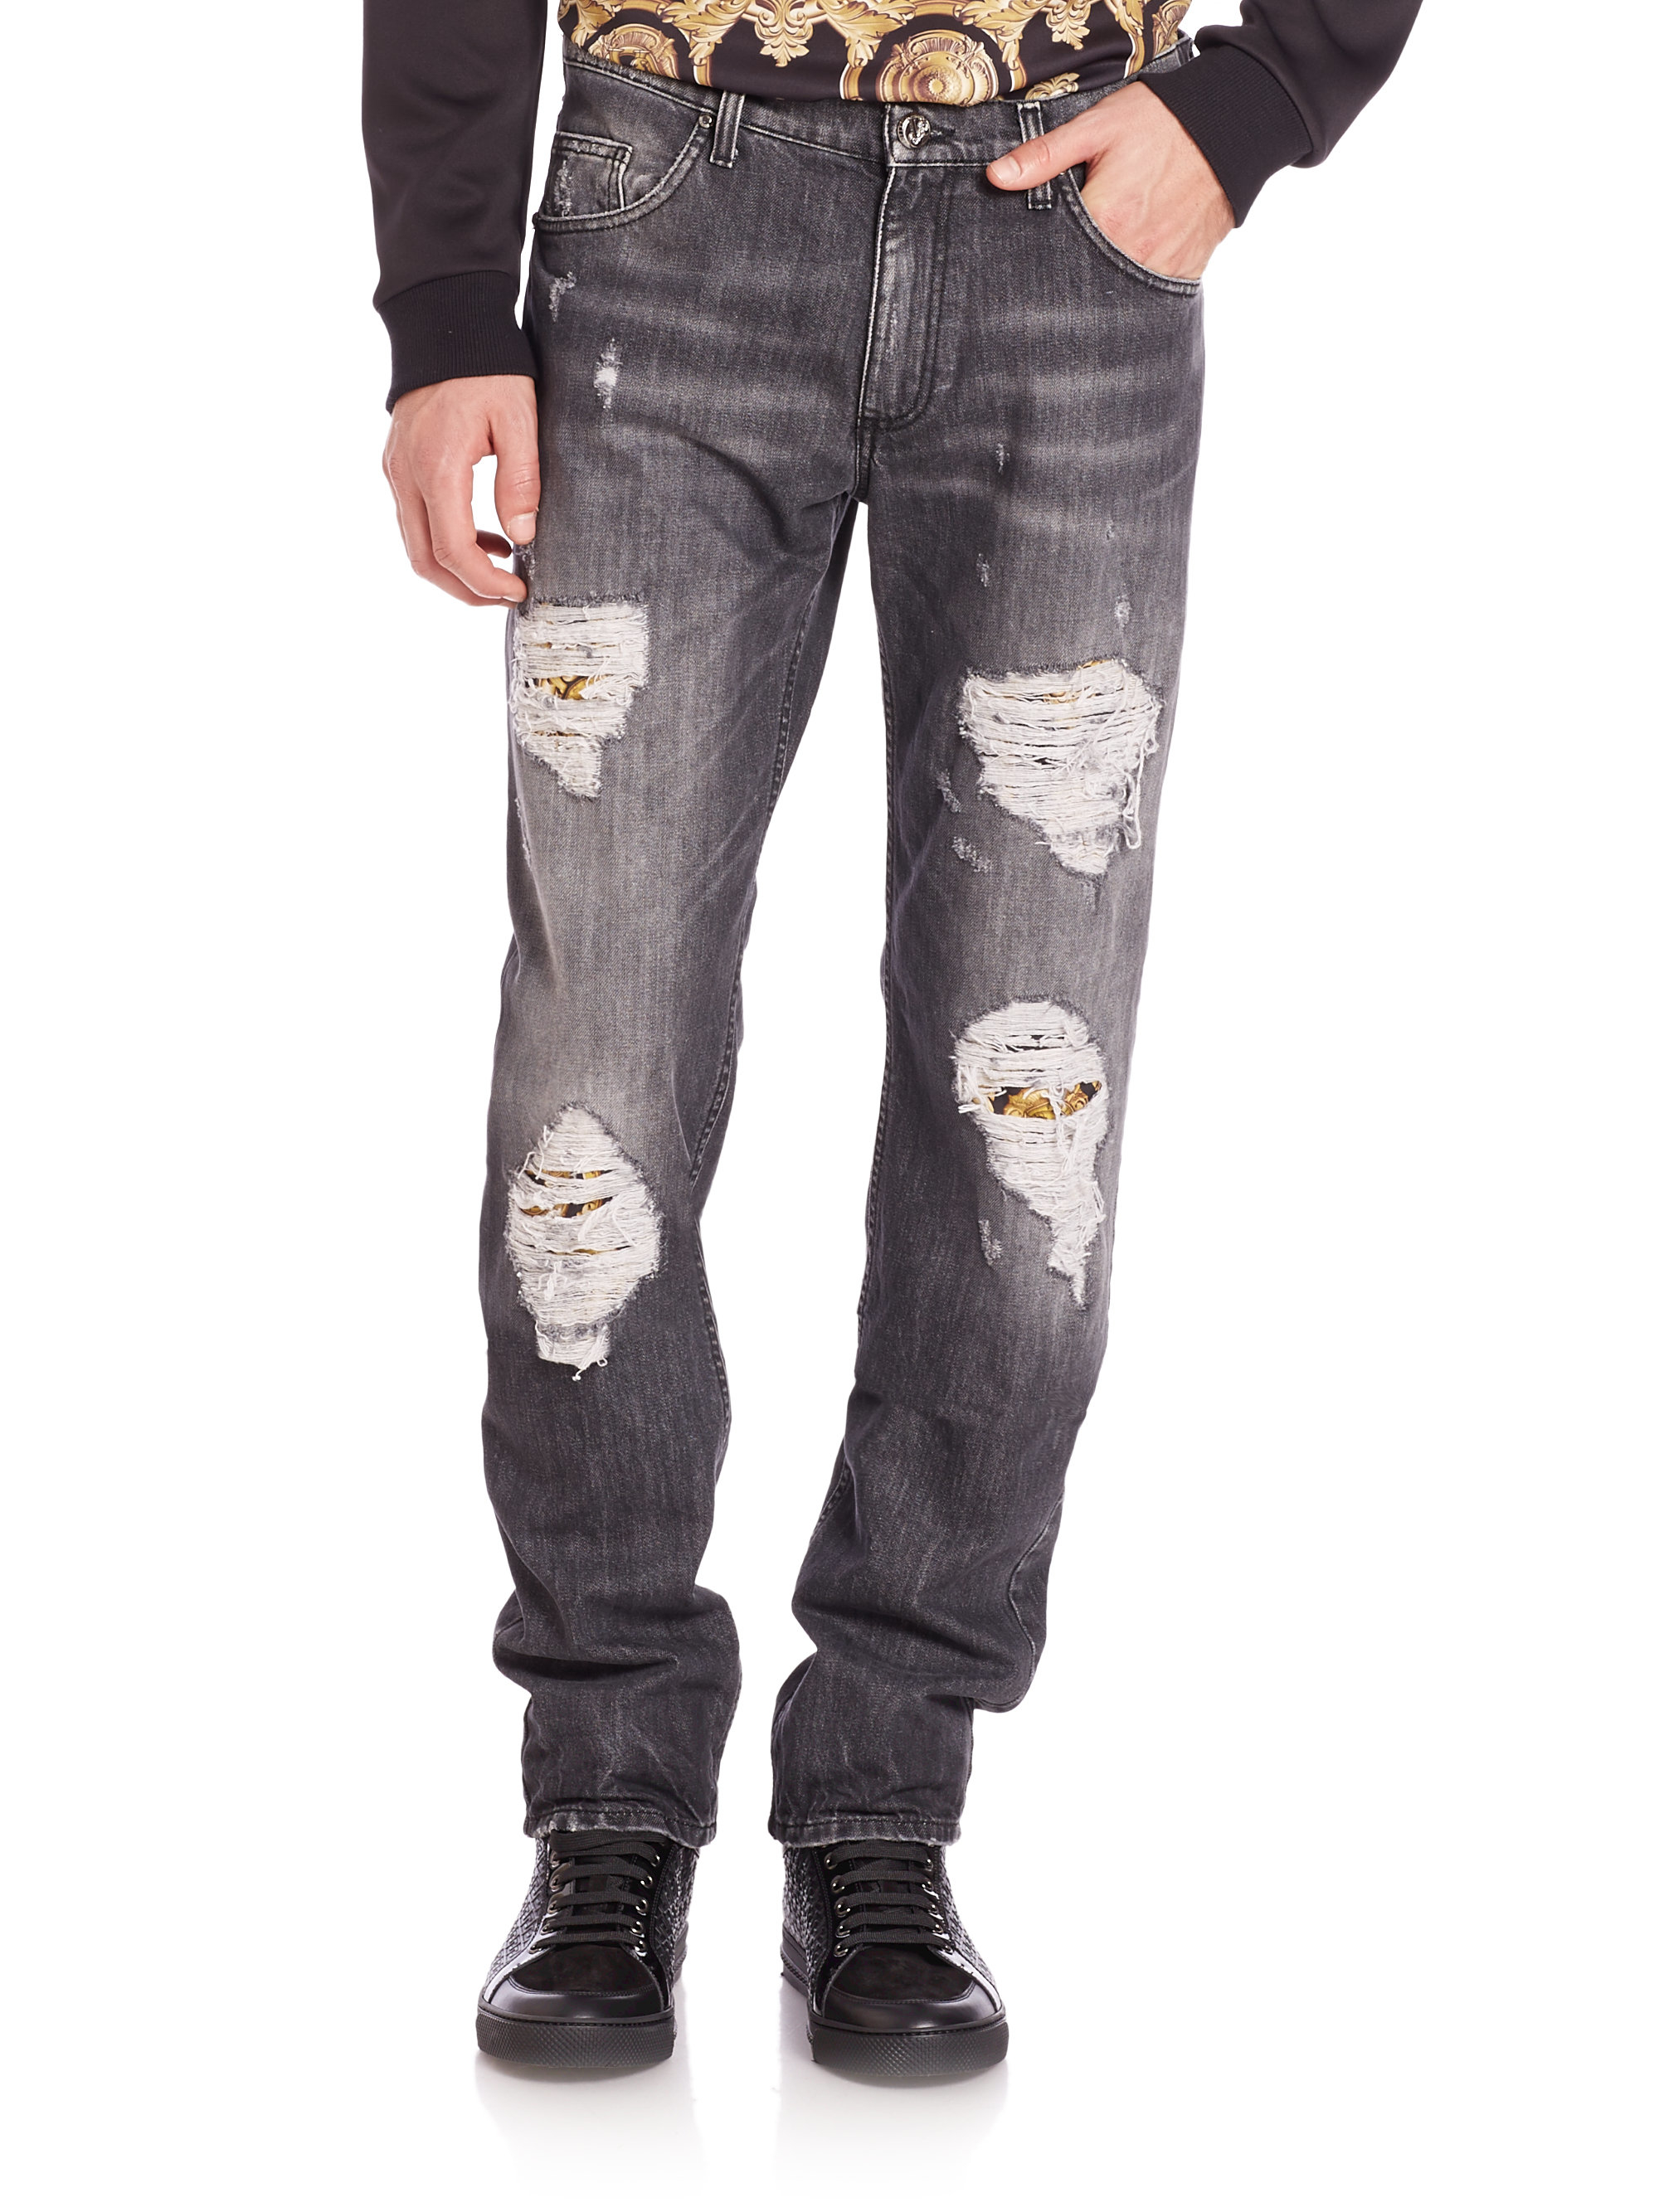

black_jeans



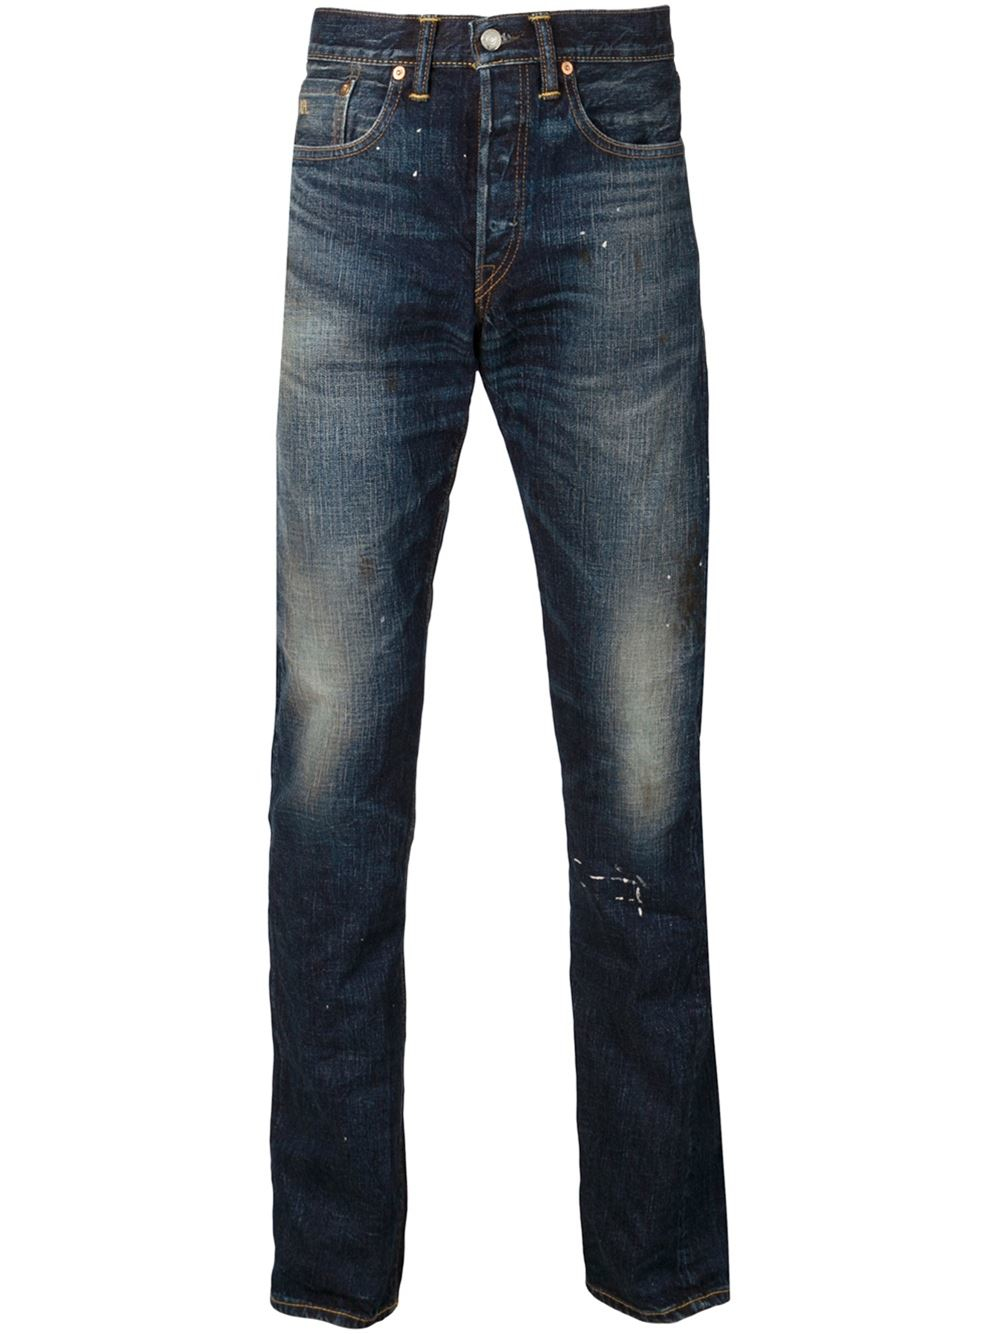

blue_jeans



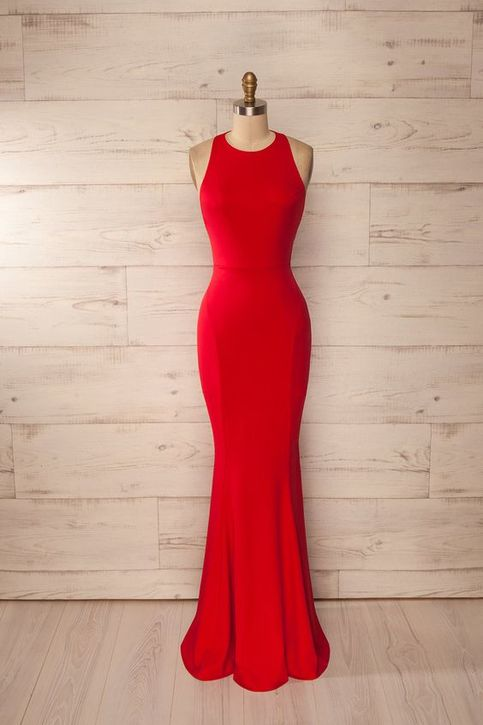

red_dress



In [21]:
for n in range(3):
    image_index = random.choice(range(len(all_img_path)))
    display.display(display.Image(all_img_path[image_index], width = 100, height = 100))
    print(all_img_labels[image_index])
    print()

加载和格式化图像

In [22]:
img_path = all_img_path[0]
img_path

'data\\moc.\\dataset\\blue_jeans\\00000200.jpg'

In [23]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+'...')

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [24]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(1200, 800, 3)
<dtype: 'uint8'>


In [25]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image/255.0
    image = 2*image-1
    return image

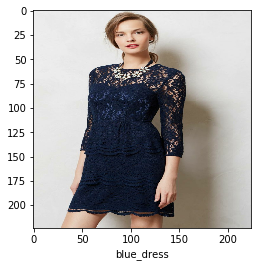

In [26]:
image_path = all_img_path[2]
label = all_img_labels[2]

plt.imshow((load_and_preprocess_image(image_path) + 1)/2)
plt.grid(False)
plt.xlabel(label)
print()

In [27]:
path_ds = tf.data.Dataset.from_tensor_slices(all_img_path)

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [29]:
label_ds = tf.data.Dataset.from_tensor_slices((color_labels, item_labels))

In [30]:
for ele in label_ds.take(3):
    print(ele[0].numpy(), ele[1].numpy())

1 2
2 2
1 0


In [31]:
image_label_ds = tf.data.Dataset.zip((img_ds, label_ds))

In [32]:
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

In [33]:
test_count = int(img_count*0.2)
train_count = img_count - test_count

In [34]:
train_data = image_label_ds.skip(test_count)

test_data = image_label_ds.take(test_count)

In [35]:
BATCH_SIZE = 32

In [36]:
train_data = train_data.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=train_count))
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [37]:
test_data = test_data.batch(BATCH_SIZE)
test_data

<BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

# 建立模型

In [38]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)

In [39]:
input = tf.keras.Input(shape = (224, 224, 3))

In [40]:
x = mobile_net(input)
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [41]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [42]:
x.get_shape()

TensorShape([None, 1280])

In [43]:
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
output_color = tf.keras.layers.Dense(len(color_label_names), 
                                     activation='softmax', 
                                     name = 'out_put_color')(x1)   #对color的输出模型

In [44]:
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
output_item = tf.keras.layers.Dense(len(item_label_names), 
                                    activation='softmax', 
                                    name = 'out_put_item')(x2)   #对item的输出模型

In [45]:
model = tf.keras.Model(inputs = input, 
                      outputs = [output_color, output_item])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1311744     global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [47]:
model.compile(optimizer='adam',
             loss={'out_put_color':'sparse_categorical_crossentropy',
                   'out_put_item':'sparse_categorical_crossentropy'},
              metrics=['acc']
             )

In [48]:
train_steps = train_count//BATCH_SIZE
test_steps = test_count//BATCH_SIZE
train_steps,test_steps

(63, 15)

In [49]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [50]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=train_steps,
                    validation_data=test_data,
                    validation_steps=test_steps)

Train for 63 steps, validate for 15 steps
Epoch 1/3
63/63 [==============================] - 86s 1s/step - loss: 0.5519 - out_put_color_loss: 0.2636 - out_put_item_loss: 0.2882 - out_put_color_acc: 0.9147 - out_put_item_acc: 0.9142 - val_loss: 7.7216 - val_out_put_color_loss: 4.9996 - val_out_put_item_loss: 2.7220 - val_out_put_color_acc: 0.6458 - val_out_put_item_acc: 0.8062
Epoch 2/3
63/63 [==============================] - 57s 902ms/step - loss: 0.1977 - out_put_color_loss: 0.0835 - out_put_item_loss: 0.1142 - out_put_color_acc: 0.9757 - out_put_item_acc: 0.9683 - val_loss: 4.1348 - val_out_put_color_loss: 3.0048 - val_out_put_item_loss: 1.1300 - val_out_put_color_acc: 0.7042 - val_out_put_item_acc: 0.8625
Epoch 3/3
63/63 [==============================] - 58s 914ms/step - loss: 0.1171 - out_put_color_loss: 0.0600 - out_put_item_loss: 0.0571 - out_put_color_acc: 0.9821 - out_put_item_acc: 0.9841 - val_loss: 1.1680 - val_out_put_color_loss: 0.3753 - val_out_put_item_loss: 0.7926 - va

In [51]:
history.history.keys()

dict_keys(['loss', 'out_put_color_loss', 'out_put_item_loss', 'out_put_color_acc', 'out_put_item_acc', 'val_loss', 'val_out_put_color_loss', 'val_out_put_item_loss', 'val_out_put_color_acc', 'val_out_put_item_acc'])

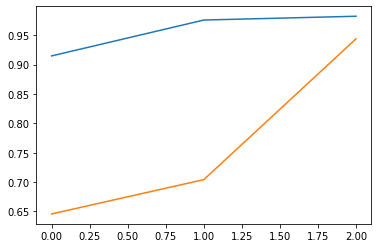

In [53]:
plt.plot(history.epoch, history.history.get('out_put_color_acc'), label='out_put_color_acc')
plt.plot(history.epoch, history.history.get('val_out_put_color_acc'), label='val_out_put_color_acc')

In [59]:
model.evaluate(test_data,verbose=0)   #对测试集进行预测

[1.2449188344180584, 0.38702136, 0.8578975, 0.94257426, 0.86732674]

In [114]:
#my_image = load_and_preprocess_image(r'{}'.format(random.choice(all_img_path)))
my_image = load_and_preprocess_image(r'd:/test.jpg')   #对网上下载图片的预测


In [115]:
my_image.shape

TensorShape([224, 224, 3])

In [116]:
my_image = np.expand_dims(my_image, 0)   #tf.expand_dims方法一样增加维度

In [117]:
my_image.shape

(1, 224, 224, 3)

In [118]:
pre = model.predict(my_image)    #对单个数据进行预测
pre

[array([[5.2113067e-20, 1.0000000e+00, 3.6809020e-15]], dtype=float32),
 array([[1.00000000e+00, 1.55739404e-08, 1.06588884e-10, 1.52876440e-18]],
       dtype=float32)]

In [128]:
pre = model(my_image, training=True)    #直接调用model对图片进行预测,是否开启训练模式，不开启则不会对模型产生变化

In [129]:
pre_color = color_index_to_label.get(np.argmax(pre[0][0]))
pre_item = item_index_to_label.get(np.argmax(pre[1][0]))
pred = pre_color+'_'+pre_item

Text(0.5, 0, 'blue_dress')

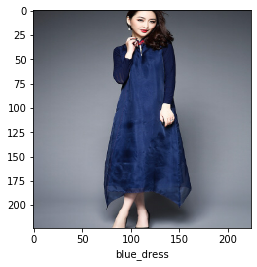

In [130]:
plt.imshow((my_image[0]+1)/2)    #反归一化
plt.xlabel(pred)